In [42]:
# pip install SentencePiece

In [43]:
from datasets import load_dataset
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU available


In [44]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

In [45]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

train_df = train_data.to_pandas()
train_df.drop(['query_id', 'query_type', 'wellFormedAnswers'], axis=1, inplace=True)
train_df = train_df[:82326]
train_df.head()

,answers,passages,query
0,[Results-Based Accountability is a disciplined...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",what is rba
1,[Yes],"{'is_selected': [0, 1, 0, 0, 0, 0, 0], 'passag...",was ronald reagan a democrat
2,[20-25 minutes],"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...",how long do you need for sydney and surroundin...
3,[$11 to $22 per square foot],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",price to install tile in shower
4,[Due to symptoms in the body],"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0], 'pas...",why conversion observed in body


In [46]:
passage = []
answer = []

for i in range(len(train_df)):
    x = train_df['answers'][i].tolist()
    if len(x)==0:
        x = "-"
    passage.append((train_df['passages'][i]['passage_text']).tolist())
    answer.append(x[0])

train_df['passages'] = passage
train_df['answers'] = answer
train_df = train_df[['query', 'answers', 'passages']]
train_df.head()

,query,answers,passages
0,what is rba,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ..."
1,was ronald reagan a democrat,Yes,"[In his younger years, Ronald Reagan was a mem..."
2,how long do you need for sydney and surroundin...,20-25 minutes,"[Sydney, New South Wales, Australia is located..."
3,price to install tile in shower,$11 to $22 per square foot,"[In regards to tile installation costs, consum..."
4,why conversion observed in body,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org..."


In [47]:
# train_df['answers'][0]

In [48]:
unique_docs = []
for i in range(len(train_df)):
    x = train_df['passages'][i]
    for j in range(len(x)):
        unique_docs.append(x[j])
print(len(unique_docs))
unique_docs = list(set(unique_docs))
unique_docs[:5]

676193


['Feminine form of ALEXANDER. In Greek mythology this was a Mycenaean epithet of the goddess Hera, and an alternate name of Cassandra. It was borne by several early Christian saints, and also by the wife of Nicholas II, the last czar of Russia. ',
 'However, the program eventually failed in 1963 because of poor executions. By March 1964, Viet Cong had controlled about 40% of the South Vietnamese rural territories including 80% of Phuoc Tuy, 90% of Binh Duong, 90% of Kien Tuong, 90% of Kien Hoa, and 85% of An Xuyen 5 …. Since 1965, the war gradually shifted from guerrilla to conventional war. The numbers of battles in battalion-size or larger increased quickly during 1965 and 1966 6. As villages were not suitable for conventional combats, most of the fightings in this period took place far away from populated areas.',
 'The part of the autonomic nervous system originating in the brain stem and the lower part of the spinal cord that, in general, inhibits or opposes the physiological effe

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer

# Load pre-trained models and tokenizers
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(t5_model)

trainable params: 222903552 || all params: 222903552 || trainable%: 100.0


In [51]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(r=16, 
                        lora_alpha=32, 
                        target_modules=["q", "v"], 
                        lora_dropout=0.05, 
                        bias="none", 
                        task_type="SEQ_2_SEQ_LM")

lora_model = get_peft_model(t5_model, lora_config)

In [52]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(lora_model)

trainable params: 1769472 || all params: 224673024 || trainable%: 0.7875765272113843


## Encode queries and retrieve top-k relevant documents

In [53]:
queries = train_df['query'].tolist()
answers = train_df['answers'].tolist()
k_value = 10 # Top 10 documents

all_docs = unique_docs
doc_embeddings = sentence_transformer.encode(all_docs)

# Create FAISS index and store document embeddings
import faiss
index = faiss.IndexFlatIP(doc_embeddings.shape[1])
index.add(doc_embeddings)

query_embeddings = sentence_transformer.encode(queries)

# Create a list to store the inputs
inputs = []

for i in tqdm(range(len(queries)), desc="encoding query and finding top 10"):
    query = queries[i]
    answer = answers[i]
    query_embedding = query_embeddings[i]
    topk_doc_scores, topk_doc_indices = index.search(query_embedding.reshape(1, -1), k_value)
    top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]

    topk_doc_scores = F.softmax(torch.tensor(topk_doc_scores[0]), dim=0)
    
    for j, doc_idx in enumerate(topk_doc_indices[0]):
        inputs.append((f"{query} {all_docs[doc_idx]}", answer, topk_doc_scores[j].item()))
        # print(inputs[j])
    

# Define custom dataset and dataloader
class QADataset(torch.utils.data.Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

dataset = QADataset(inputs)
print(f"\ndataset is {dataset}")
for i, j, k in dataset:
    print(i)
    print(j)
    print(k)
    break

dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=False)
print(f"\ndataloader is {dataloader}")
for i, j, k in dataloader:
    print(i)
    print(j)
    print(k)
    break

encoding query and finding top 10: 100%|██████████| 82326/82326 [4:31:46<00:00,  5.05it/s]  



dataset is <__main__.QADataset object at 0x7fef18611510>
what is rba Get To Know Us. RBA is a digital and technology consultancy with roots in strategy, design and technology. Our team of specialists help progressive companies deliver modern digital experiences backed by proven technology engineering. 
Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.
0.12032518535852432

dataloader is <torch.utils.data.dataloader.DataLoader object at 0x7feef5e73640>
('what is rba Get To Know Us. RBA is a digital and technology consultancy with roots in strategy, design and technology. Our team of specialists help progressive companies deliver modern digital experiences backed by proven technology engineering. ', 'what is rba RBA stands for ReBuildable Atomizer. They are rebuildable/reusable versions of the standard disposables items that every vaper knows – ca

In [54]:
torch.save(dataset, 'processed_dataset.pth')
print("Dataset has been saved to 'processed_dataset.pth'")

Dataset has been saved to 'processed_dataset.pth'


In [58]:
# Load the dataset
dataset = torch.load('processed_dataset.pth')
# Recreate the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=False)

In [59]:
len(dataloader)

82326

In [14]:
# # Load and encode documents
# all_docs = ["Involuntary muscles are muscles that are not controllable consciously.",
#             "Muscles are good for what ",
#             "Voluntary muscles good ",
#             "paloma did sleep"]
    
# all_docs = all_docs
# doc_embeddings = sentence_transformer.encode(all_docs)

# # Create FAISS index and store document embeddings
# import faiss
# index = faiss.IndexFlatIP(doc_embeddings.shape[1])
# index.add(doc_embeddings)

# # Encode query and retrieve top-k relevant documents
# query = "who slept last night"
# answer = "it is paloma"
# query_embedding = sentence_transformer.encode([query])[0]
# k_value = 10
# _, topk_doc_indices = index.search(query_embedding.reshape(1, -1), k_value)
# top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]
# print(f"\ntop_docs are :")
# for i in top_docs:
#     print(i)

# # Compute softmax scores for top-k documents
# topk_doc_scores, _ = index.search(query_embedding.reshape(1, -1), k_value)
# topk_doc_scores = F.softmax(torch.tensor(topk_doc_scores[0]), dim=0)
# print(f"\nsoftmax_scores are \n{topk_doc_scores}")

# # Prepare input for encoder-decoder model
# inputs = []
# for i, doc_idx in enumerate(topk_doc_indices[0]):
#     inputs.append((f"{query} {all_docs[doc_idx]}", answer, topk_doc_scores[i].item()))
# print(f"\ninputs are :")
# for i in inputs:
#     print(i)

# # Define custom dataset and dataloader
# class QADataset(torch.utils.data.Dataset):
#     def __init__(self, inputs):
#         self.inputs = inputs

#     def __len__(self):
#         return len(self.inputs)

#     def __getitem__(self, idx):
#         return self.inputs[idx]

# dataset = QADataset(inputs)
# print(f"\ndataset is {dataset}")
# for i, j, k in dataset:
#     print(i)
#     print(j)
#     print(k)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=k_value, shuffle=True)
# print(f"\ndataloader is {dataloader}")
# for i, j, k in dataloader:
#     print(i)
#     print(j)
#     print(k)

## Model class

In [72]:
import os
class QAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.t5 = lora_model

    def forward(self, input_ids, attention_mask, decoder_input_ids, labels=None):
        outputs = self.t5(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,  #causal mask is handled internally
            labels=labels
        )
        return outputs

model = QAModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 20

save_path = '/workspace/RAG/'
checkpoint_path = os.path.join(save_path, 'model_checkpoint.pth')
os.makedirs(save_path, exist_ok=True)

In [16]:
# model_loss = []
# new_loss = []

# for epoch in range(epochs):
#     epoch_loss = 0.0
#     epoch_model_loss = 0.0
    
#     progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
    
#     for inputs, answer, score in progress_bar:
#         inputs_dict = t5_tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=512)
#         input_ids = inputs_dict['input_ids']
#         attention_mask = inputs_dict['attention_mask']

#         answer_dict = t5_tokenizer(answer, return_tensors='pt', padding=True, truncation=True, max_length=512)
#         answer_dict_ids = answer_dict['input_ids']
#         answer_dict_attention_mask = answer_dict['attention_mask']

#         decoder_inputs = answer_dict_ids[:, :-1].contiguous()
#         labels = answer_dict_ids[:, 1:].contiguous()

#         score = score.unsqueeze(1).unsqueeze(2)

#         outputs = model(input_ids, attention_mask, decoder_inputs, labels=labels)  # causal mask is handled internally

#         softmaxed_logits = F.softmax((outputs['logits']), dim=2)
#         final = score * softmaxed_logits
#         final_result = final.sum(dim=0, keepdim=True)

#         predictions = final_result.view(-1, final_result.size(-1))
#         flat_labels = decoder_inputs[0].view(-1)
#         loss = F.cross_entropy(predictions, flat_labels)

#         epoch_loss += loss.item()
#         epoch_model_loss += outputs.loss.item()

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # Update tqdm progress bar description with current loss
#         progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}")

#     # Print the average loss for the epoch
#     print(f"-" * 100)
#     print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {epoch_loss / len(dataloader):.4f}")
#     print(f"Epoch {epoch + 1}/{epochs} - Average Model Loss: {epoch_model_loss / len(dataloader):.4f}")
#     print(f"-" * 100)

#     model_loss.append(epoch_model_loss / len(dataloader))
#     new_loss.append(epoch_loss / len(dataloader))

## Training

In [73]:
# batch adjusted

model.to(device)

our_loss = []
model_loss = []

max_batches_per_epoch = 100  

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_model_loss = 0.0
    batch_count = 0 

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
    
    for inputs, answer, score in progress_bar:
        if batch_count >= max_batches_per_epoch:
            break  # Stop processing after max_batches_per_epoch batches

        # Tokenize and move inputs to GPU
        inputs_dict = t5_tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=512)
        input_ids = inputs_dict['input_ids'].to(device)
        attention_mask = inputs_dict['attention_mask'].to(device)

        # Tokenize and move answers to GPU
        answer_dict = t5_tokenizer(answer, return_tensors='pt', padding=True, truncation=True, max_length=512)
        answer_dict_ids = answer_dict['input_ids'].to(device)
        decoder_inputs = answer_dict_ids[:, :-1].contiguous()
        labels = answer_dict_ids[:, 1:].contiguous()

        # Ensure score tensor is on GPU
        score = score.to(device).unsqueeze(1).unsqueeze(2)

        # Forward pass
        outputs = model(input_ids, attention_mask, decoder_inputs, labels=labels)  # causal mask is handled internally
        softmaxed_logits = torch.nn.functional.softmax(outputs.logits, dim=2)
        final = score * softmaxed_logits
        final_result = final.sum(dim=0, keepdim=True)

        # Compute custom loss
        predictions = final_result.view(-1, final_result.size(-1))
        flat_labels = decoder_inputs[0].view(-1)
        loss = torch.nn.functional.cross_entropy(predictions, flat_labels)

        epoch_loss += loss.item()
        epoch_model_loss += outputs.loss.item()

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar and batch count
        progress_bar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f}")
        batch_count += 1

    # Save the model state at the end of the epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }, checkpoint_path)
    
    # Record and print average losses for the epoch
    our_loss.append(epoch_loss / max_batches_per_epoch)
    model_loss.append(epoch_model_loss / max_batches_per_epoch)
    print(f"Epoch {epoch + 1}/{epochs} - ----- Our Loss: {epoch_loss / max_batches_per_epoch:.4f}")
    print(f"Epoch {epoch + 1}/{epochs} - Model Loss: {epoch_model_loss / max_batches_per_epoch:.4f}")
    
    # model.eval()  # Set model to evaluation mode
    # with torch.no_grad():
    #     valid_loss = 0.0
    #     for data in valid_loader:
    #         inputs, labels = data
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    #         valid_loss += loss.item()
    #     print(f'Validation Loss: {valid_loss / len(valid_loader)}')


Epoch 1/20 - ----- Our Loss: 9.3805
Epoch 1/20 - Model Loss: 22.5662


Epoch 2/20 - ----- Our Loss: 9.3800
Epoch 2/20 - Model Loss: 22.6282


Epoch 3/20 - ----- Our Loss: 9.3798
Epoch 3/20 - Model Loss: 22.6805


Epoch 4/20 - ----- Our Loss: 9.3796
Epoch 4/20 - Model Loss: 22.7374


Epoch 5/20 - ----- Our Loss: 9.3795
Epoch 5/20 - Model Loss: 22.7774


Epoch 6/20 - ----- Our Loss: 9.3793
Epoch 6/20 - Model Loss: 22.7956


Epoch 7/20 - ----- Our Loss: 9.3789
Epoch 7/20 - Model Loss: 22.8107


Epoch 8/20 - ----- Our Loss: 9.3788
Epoch 8/20 - Model Loss: 22.8563


Epoch 9/20 - ----- Our Loss: 9.3787
Epoch 9/20 - Model Loss: 22.9051


Epoch 10/20 - ----- Our Loss: 9.3787
Epoch 10/20 - Model Loss: 22.9455


Epoch 11/20 - ----- Our Loss: 9.3786
Epoch 11/20 - Model Loss: 22.9976


Epoch 12/20 - ----- Our Loss: 9.3786
Epoch 12/20 - Model Loss: 23.0385


Epoch 13/20 - ----- Our Loss: 9.3785
Epoch 13/20 - Model Loss: 23.0782


Epoch 14/20 - ----- Our Loss: 9.3785
Epoch 14/20 - Model Loss: 23.1186


Epoch 15/20 - ----- Our Loss: 9.3784
Epoch 15/20 - Model Loss: 23.1607


Epoch 16/20 - ----- Our Loss: 9.3784
Epoch 16/20 - Model Loss: 23.2070


Epoch 17/20 - ----- Our Loss: 9.3783
Epoch 17/20 - Model Loss: 23.2383


Epoch 18/20 - ----- Our Loss: 9.3783
Epoch 18/20 - Model Loss: 23.2753


Epoch 19/20 - ----- Our Loss: 9.3783
Epoch 19/20 - Model Loss: 23.3157


Epoch 20/20 - ----- Our Loss: 9.3783
Epoch 20/20 - Model Loss: 23.3422


In [74]:
our_loss, model_loss

([9.380529931640693,
  9.380031677870324,
  9.37978298384778,
  9.379620706042285,
  9.379461540351523,
  9.379280284365967,
  9.378908847911816,
  9.378817162271815,
  9.378737169139882,
  9.378672637359053,
  9.378610849779934,
  9.378557599470824,
  9.378503503734116,
  9.378458400716434,
  9.378423184752089,
  9.378380312340273,
  9.378341545593617,
  9.378314832661978,
  9.378280815871907,
  9.378253497962579],
 [22.566160259246825,
  22.628224830627442,
  22.68045867919922,
  22.737388286590576,
  22.777408618927,
  22.795561599731446,
  22.810731143951415,
  22.856279830932618,
  22.905063304901123,
  22.945488376617433,
  22.997629108428956,
  23.038520584106447,
  23.078159084320067,
  23.11859266281128,
  23.160689220428466,
  23.207026538848876,
  23.23833547592163,
  23.275337753295897,
  23.31565788269043,
  23.342175731658937])

In [19]:
# model_loss = []
# new_loss = []

# for epoch in range(epochs):
#     for inputs, answer, score in dataloader:
#         inputs_dict = t5_tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=512)
#         input_ids = inputs_dict['input_ids']
#         attention_mask = inputs_dict['attention_mask']

#         print(f"\ninput_ids are {input_ids.shape}\n{input_ids}")
#         print(f"input attention_mask are {attention_mask.shape}\n{attention_mask}")

#         answer_dict = t5_tokenizer(answer, return_tensors='pt', padding=True, truncation=True, max_length=512)
#         answer_dict_ids = answer_dict['input_ids']
#         answer_dict_attention_mask = answer_dict['attention_mask']
#         print(f"\nanaswer_dict are {answer_dict_ids.shape}\n{answer_dict_ids}")
#         print(f"anaswer_dict_attention_mask are {answer_dict_attention_mask.shape}\n{answer_dict_attention_mask}")
        
#         print("" + "-" * 100)

#         decoder_inputs = answer_dict_ids[:, :-1].contiguous()
#         print(f"\ndecoder_inputs is {decoder_inputs.shape}\n{decoder_inputs}")
#         labels = answer_dict_ids[:, 1:].contiguous()
#         print(f"labels is {labels.shape}\n{labels}")
#         score = score.unsqueeze(1).unsqueeze(2)
#         print(f"\nscore is {score.shape}\n{score}")

#         outputs = model(input_ids, attention_mask, decoder_inputs, labels=labels) #causal mask is handled internally
#         print("\nDecoder done" + "-" * 100)
#         print(f"\noutputs is {outputs.keys()}\n\nloslogitss is {outputs['loss']}\n\nlogits is {outputs['logits'].shape}\n{outputs['logits']}")
#         softmaxed_logits = F.softmax((outputs['logits']), dim=2)
#         print(f"\nsoftmaxed_logits are {softmaxed_logits.shape}\n{softmaxed_logits}")
#         print(f"\nThe sum of 1st row is {softmaxed_logits[0, 0].sum()}")
#         print("\nPrinted outputs" + "-" * 100)
#         final = score * softmaxed_logits
#         print(f"\nAfter multiplied to softmax are {final.shape}\n{final}")
#         final_result = final.sum(dim=0, keepdim=True) 
#         print(f"\nAfter summed are {final_result.shape}\n{final_result}")
#         print(f"\nThe sum of 1st row is {final_result[0, 0].sum()}")
#         print("\nMarginalise done" + "-" * 100)
#         # loss = outputs.loss # I wont be interested in this loss
#         predictions = final_result.view(-1,final_result.size(-1))
#         flat_labels = decoder_inputs[0].view(-1)
#         print(f"predictions shape is {predictions.shape}")
#         print(f"flat_labels shape is {flat_labels.shape}")
#         loss = F.cross_entropy(predictions, flat_labels)
#         model_loss.append(outputs.loss)
#         new_loss.append(loss)
#         print(f"\nloss is {loss}")
#         print(f"\nmodel loss is {outputs.loss}")

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         print(f"\nEPOCH {epoch} DONE" + "-" * 100)

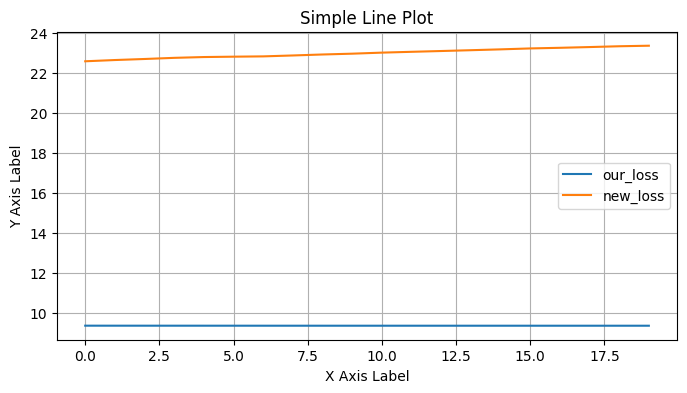

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))  
plt.plot(our_loss,label='our_loss')
plt.plot(model_loss, label='new_loss')  
plt.title('Simple Line Plot')  
plt.xlabel('X Axis Label')  
plt.ylabel('Y Axis Label') 
plt.legend()  
plt.grid(True) 
plt.show()

In [21]:
answer ='example of involuntary muscle tissue is Muscles '
tokens = ['▁yes', ',', '▁you', '▁are', '▁right']
print(t5_tokenizer.tokenize(answer), t5_tokenizer.convert_tokens_to_ids(tokens))
len(['▁example', '▁of', '▁in', 'vol', 'unta', 'ry', '▁muscle', '▁tissue', '▁is', '▁Mus', 'cle', 's'])

['▁example', '▁of', '▁in', 'vol', 'unta', 'ry', '▁muscle', '▁tissue', '▁is', '▁Mus', 'cle', 's'] [4273, 6, 25, 33, 269]


12

In [22]:
t5_tokenizer.decode(1), t5_tokenizer.decode(0),  t5_tokenizer.pad_token_id

('</s>', '<pad>', 0)

In [23]:
t5_tokenizer.decode([4273,    6,   25,   33,  269,    1])

'yes, you are right</s>'

In [24]:
model_path = "/workspace/RAG/trained_model.pth"

torch.save(model.state_dict(), model_path)


In [25]:
# model = QAModel()
# model.load_state_dict(torch.load('/workspace/RAG/trained_model.pth'))
# model.eval()
# model.to(device)

# tokenizer = T5Tokenizer.from_pretrained('t5-base')

# def generate_answer(query, max_length=128):
#     inputs = tokenizer.encode(query, return_tensors="pt", add_special_tokens=True)
#     inputs = inputs.to(device)  # Move inputs to the correct device

#     # Generate outputs using the model
#     with torch.no_grad():
#         outputs = model.t5.generate(input_ids=inputs, 
#                                     max_length=max_length, 
#                                     num_beams=5, 
#                                     no_repeat_ngram_size=2,
#                                     early_stopping=True)

#     # Decode and return the generated text
#     answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return answer

# # Example usage:
# query = "What is the capital of France?"
# answer = generate_answer(query)
# print("Generated Answer:", answer)

## Inference

In [ ]:
model = QAModel()
model.load_state_dict(torch.load('/workspace/RAG/trained_model.pth'))
model.eval()
model.to(device)


def generate_answer(query, k_value=10, max_length=12):
    query_embedding = sentence_transformer.encode([query])
    topk_doc_scores, topk_doc_indices = index.search(query_embedding, k_value)
    top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]
    # inputs = [(f"{query} {doc}") for doc in top_docs]
    inputs = query+" "+' '.join([doc for doc in top_docs])
    print(f"{inputs}\n")
    # for i in inputs:
    #     print(i)
    
    # Encode the inputs using the tokenizer
    input_ids = t5_tokenizer.batch_encode_plus(inputs, max_length=512, padding=True, return_tensors="pt", truncation=True)
    input_ids = input_ids.to(device)
    
    # Generate responses from the model
    with torch.no_grad():
        outputs = model.t5.generate(
                                    input_ids=input_ids['input_ids'], 
                                    attention_mask=input_ids['attention_mask'],
                                    max_length=max_length, 
                                    num_beams=5, 
                                    no_repeat_ngram_size=2,
                                    early_stopping=True)
        print(f"logits is {outputs.shape}")
        
    answers = [t5_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return answers


query = "What is the capital of France?"
answers = generate_answer(query)
for answer in answers:
    print("Generated Answer:", answer)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def generate_answer(query, k_value=10, max_length=128):
    # Generate the query embedding
    query_embedding = sentence_transformer.encode([query])

    # Retrieve top-k documents using FAISS
    topk_doc_scores, topk_doc_indices = index.search(query_embedding, k_value)
    top_docs = [all_docs[idx] for idx in topk_doc_indices[0]]

    
   
    
    inputs = [f"{query} {doc}" for doc in top_docs]
    # for i in inputs:
    #     print(i)                   

    encoded_inputs = t5_tokenizer(
        inputs,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )

    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)

    print(f"input_ids are {input_ids.shape}\n{input_ids}")
    print(f"attention_mask are {attention_mask.shape}\n{attention_mask}")

    # Prepare decoder input ids with start token
    start_token_ids = torch.tensor([tokenizer.encode("<pad>")[0]]).to(device)
    decoder_input_ids = start_token_ids.unsqueeze(1)

    print(f"start_token_ids are {start_token_ids.shape}\n{start_token_ids}")
    print(f"decoder_input_ids are {decoder_input_ids.shape}\n{decoder_input_ids}")

    # Generate responses from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, decoder_input_ids)
        print(f"logits {(outputs.logits).shape}")
        predicted_ids = outputs.logits.argmax(dim=-1)

    # Decode the generated ids to text for each input
    answers = [tokenizer.decode(output, skip_special_tokens=True) for output in predicted_ids]
    return answers


# Inference
model = QAModel()
model.load_state_dict(torch.load('/workspace/RAG/trained_model.pth'))
model.eval()
model.to(device)

# Example usage
query = "What is the capital of France?"

answers = generate_answer(query)
for answer in answers:
    print("Generated Answer:", answer)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


input_ids are torch.Size([10, 193])
tensor([[ 363,   19,    8,  ...,    0,    0,    0],
        [ 363,   19,    8,  ...,    0,    0,    0],
        [ 363,   19,    8,  ...,    0,    0,    0],
        ...,
        [ 363,   19,    8,  ...,    0,    0,    0],
        [ 363,   19,    8,  ...,    0,    0,    0],
        [ 363,   19,    8,  ..., 2109,    5,    1]], device='cuda:0')
attention_mask are torch.Size([10, 193])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')
start_token_ids are torch.Size([1])
tensor([0], device='cuda:0')
decoder_input_ids are torch.Size([1, 1])
tensor([[0]], device='cuda:0')


RuntimeError: The size of tensor a (1930) must match the size of tensor b (193) at non-singleton dimension 3